**Round 2**

- Fit a Decision Tree Classifier on the training data.
- Check the accuracy on the test data.


# Import Libraries

In [26]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree

import warnings
warnings.filterwarnings("ignore")

# Load Original Data

In [27]:
def load_original_data():
    """
    Load original .csv data and return as dataframe.
    
    OUTPUT:
    :dataframe:
    """
    churnData = pd.read_csv("churnData_cleaned.csv")
    return churnData

churnData = load_original_data()

# X y Split

In [28]:
def get_X_y(df, target_feature):
    """
    Based on given dataframe split data into input and target feature(s).
    
    INPUT
    :dataframe:
    :target_feature (column):
    
    OUTPUT
    :input features dataframe (X):
    :target feature series (y):
    """
    X = df.drop([target_feature], axis=1)
    y = df[target_feature]
    return X, y

X, y = get_X_y(churnData, "Churn")

In [52]:
def get_X_numerical(X):
    X_numerical = X.select_dtypes(exclude=['object'])
    return X_numerical
    
def get_X_categorical(X):
    X_categorical = X.select_dtypes(include=['object'])
    return X_categorical

X_numerical = get_X_numerical(X)
X_categorical = get_X_categorical(X)

X_categorical_hotcoded = pd.get_dummies(X_categorical, drop_first=True)
X_hotcoded_combined = pd.concat([X_numerical, X_categorical_hotcoded], axis=1)

X_hotcoded_combined_with_y = pd.concat([X_hotcoded_combined, y], axis=1)
X_hotcoded_combined_with_y.to_csv("X_hotcoded_combined_with_y.csv", index=False)

# Train Test Split

In [30]:
def get_X_y_train_test(X, y, test_size, random_state):
    """
    INPUT
    :X - input features:
    :y - target feature:
    :test_size :
    :random_state:
    
    OUTPUT
    :X_train - input features for training:
    :X_train - input features for testing:
    :y_test - target feature for training:
    :y_train - target feature for testing:
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
    return X_train, X_test, y_train, y_test

# Model - DecisionTreeClassifier - All Data

## Functions to use

In [31]:
def DTC(max_depth, X_train, y_train, X_test, displayer=False):

    model = DecisionTreeClassifier(max_depth = max_depth)
    model.fit(X_train, y_train)

    y_pred_train_dt = model.predict(X_train)
    y_pred_test_dt = model.predict(X_test)

    performance_df = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                                   'Train': [accuracy_score(y_train, y_pred_train_dt),
                                             precision_score(y_train, y_pred_train_dt, pos_label="Yes"),
                                             recall_score(y_train, y_pred_train_dt, pos_label="Yes")],
                                   'Test': [accuracy_score(y_test, y_pred_test_dt),
                                            precision_score(y_test, y_pred_test_dt, pos_label="Yes"),
                                            recall_score(y_test, y_pred_test_dt, pos_label="Yes")]})

    if displayer:
        display(performance_df)

        fig, ax = plt.subplots(1,2, figsize=(14,8))

        plot_confusion_matrix(model,X_train,y_train,ax=ax[0], values_format = 'd')
        ax[0].title.set_text("Train Set")

        plot_confusion_matrix(model,X_test,y_test,ax=ax[1],values_format = 'd')
        ax[1].title.set_text("Test Set")
        plt.show()
    return model

In [32]:
def plot_decision_tree(model, filled, rounded, X_cols):

    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (50,25))
    plot_tree(model,filled = filled, rounded = rounded,feature_names = X_cols)
    plt.show() 

In [33]:
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv = 5, scoring = 'accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth = depth)
        cv_scores = cross_val_score(tree_model, X, y, cv = cv, scoring = scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label = 'mean cross-validation accuracy', alpha = 0.9)
    
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label = 'train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim((0.7, 0.85))
    #ax.set_ymax(1)
    ax.set_xticks(depths)
    ax.legend()

In [34]:
def report_optimal_depth():
    idx_max = sm_cv_scores_mean.argmax()
    sm_best_tree_depth = sm_tree_depths[idx_max]
    sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
    sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
    return sm_best_tree_depth, round(sm_best_tree_cv_score*100, 4), round(sm_best_tree_cv_score_std*100, 4)


In [35]:
def plot_feature_importances(model, columns):
    plt.figure(figsize=(20,14))
    plt.barh(columns, model.feature_importances_)
    plt.show()

## Naive max depth

,Error_metric,Train,Test
0,Accuracy,0.782570,0.792051
1,Precision,0.648738,0.663934
2,Recall,0.395053,0.434316


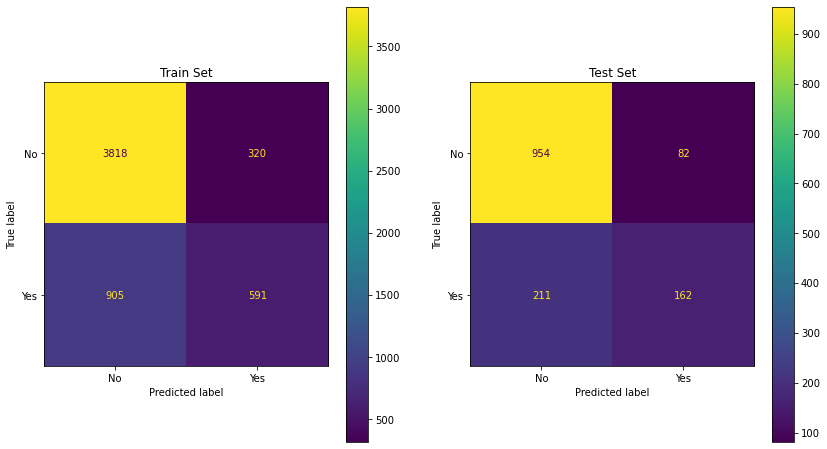

DecisionTreeClassifier(max_depth=3)

In [36]:
X_train, X_test, y_train, y_test = get_X_y_train_test(X_hotcoded_combined, y, 0.2, 42)
model_naiveDepth_allData = DTC(3, X_train, y_train, X_test, True)
model_naiveDepth_allData

## Optimized Depth

### Finding Optimal Depth via K-fold Cross-Validation

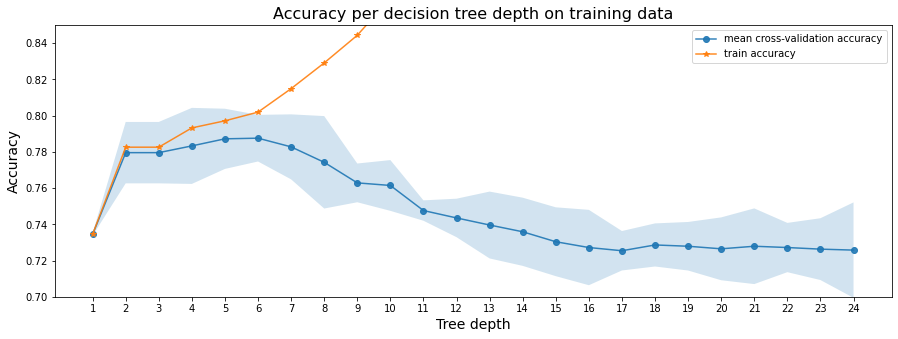

In [37]:
# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [38]:
optimalK_allData, sm_best_tree_cv_score, sm_best_tree_cv_score_std = report_optimal_depth()
print(f"The depth-{optimalK_allData} tree achieves the best mean cross-validation accuracy {sm_best_tree_cv_score} +/- {sm_best_tree_cv_score_std}% on training dataset")

The depth-6 tree achieves the best mean cross-validation accuracy 78.7539 +/- 0.6433% on training dataset


### DecisionTreeClassifier with Optimal Depth = 6

,Error_metric,Train,Test
0,Accuracy,0.801917,0.797729
1,Precision,0.690763,0.676000
2,Recall,0.459893,0.453083


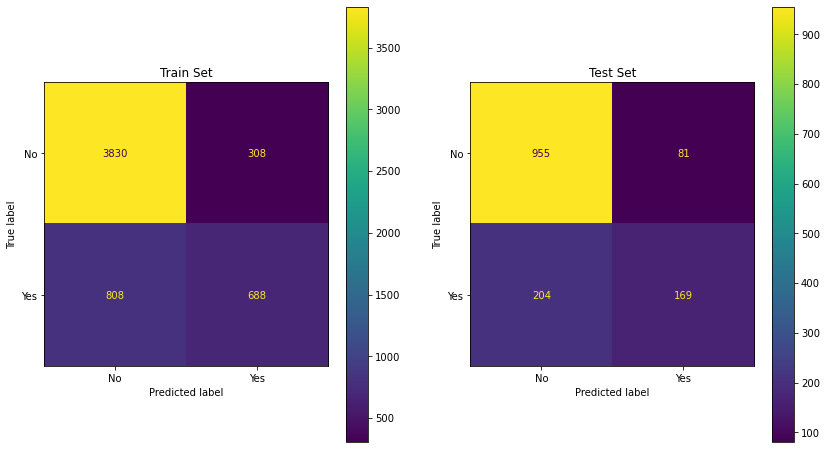

DecisionTreeClassifier(max_depth=6)

In [39]:
X_train, X_test, y_train, y_test = get_X_y_train_test(X_hotcoded_combined, y, 0.2, 42)
model_optimalK_allData = DTC(optimalK_allData, X_train, y_train, X_test, True)
model_optimalK_allData

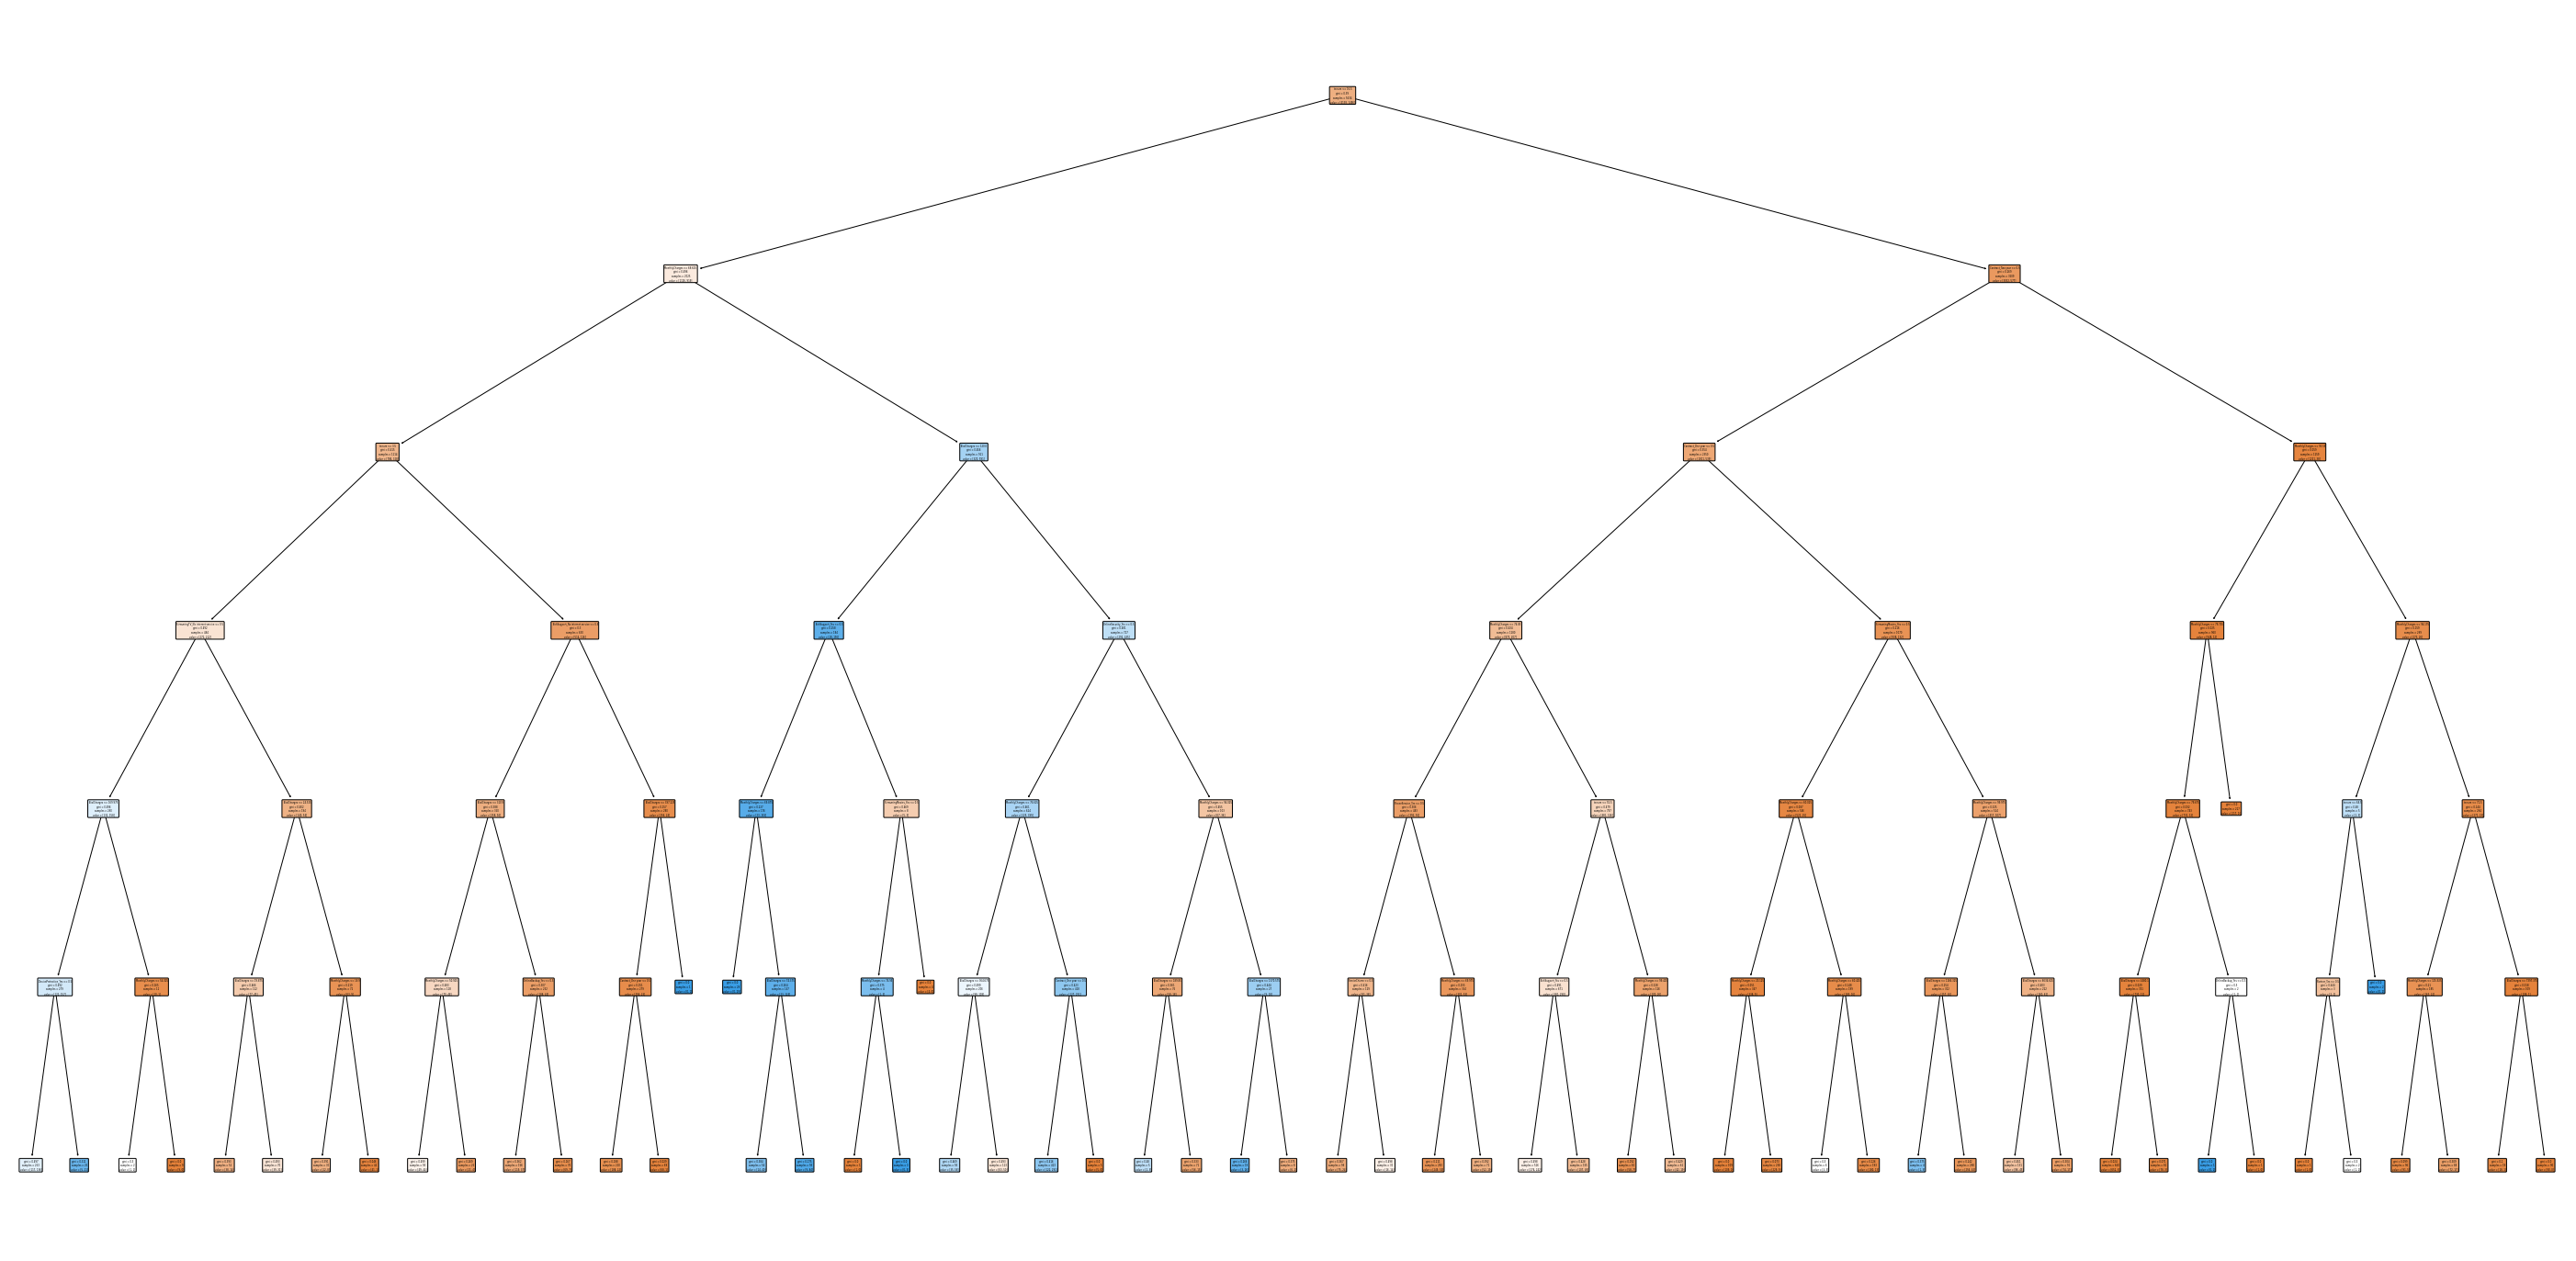

In [40]:
plot_decision_tree(model_optimalK_allData, True, True, X_hotcoded_combined.columns)

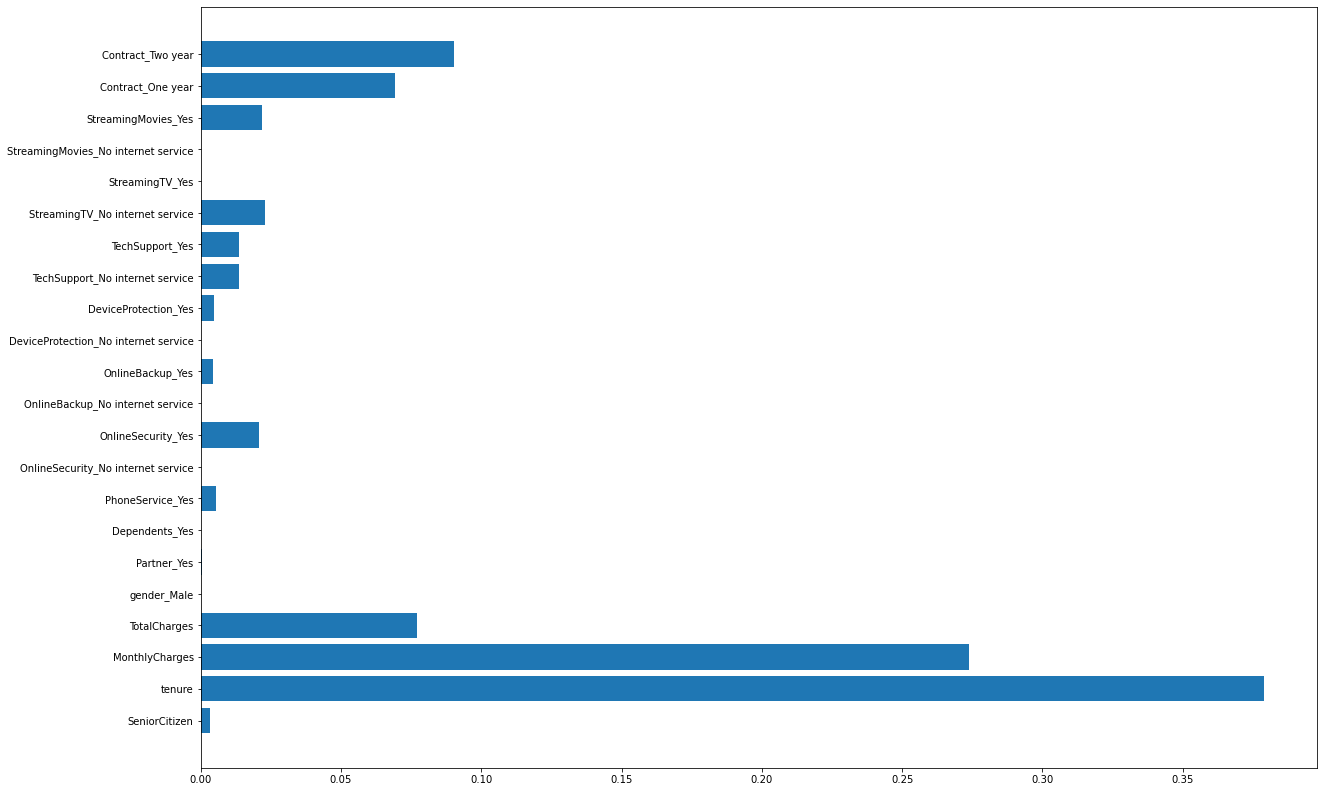

In [41]:
plot_feature_importances(model_optimalK_allData, X_hotcoded_combined.columns)

# Model - DecisionTreeClassifier - Numerical Data only

### Finding Optimal Depth via K-fold Cross-Validation

In [42]:
X_train, X_test, y_train, y_test = get_X_y_train_test(X_numerical, y, 0.2, 42)

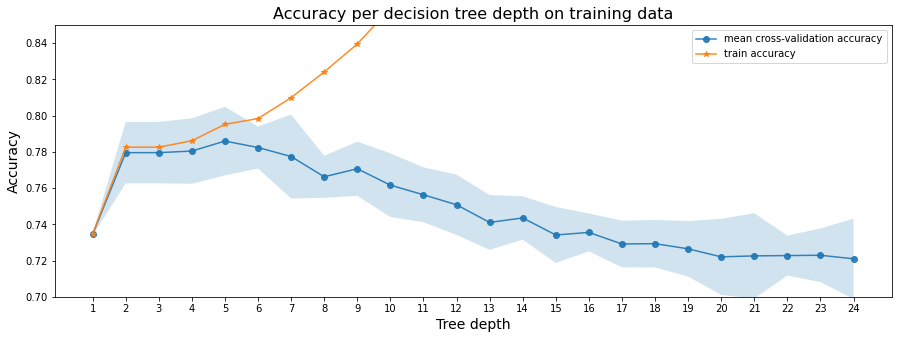

In [43]:
# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [44]:
optimalK_numerical, sm_best_tree_cv_score, sm_best_tree_cv_score_std = report_optimal_depth()
print(f"The depth-{optimalK_numerical} tree achieves the best mean cross-validation accuracy {sm_best_tree_cv_score} +/- {sm_best_tree_cv_score_std}% on training dataset")


The depth-5 tree achieves the best mean cross-validation accuracy 78.5941 +/- 0.9473% on training dataset


### DecisionTreeClassifier with Optimal Depth = 5

,Error_metric,Train,Test
0,Accuracy,0.795172,0.790632
1,Precision,0.675565,0.657258
2,Recall,0.439840,0.436997


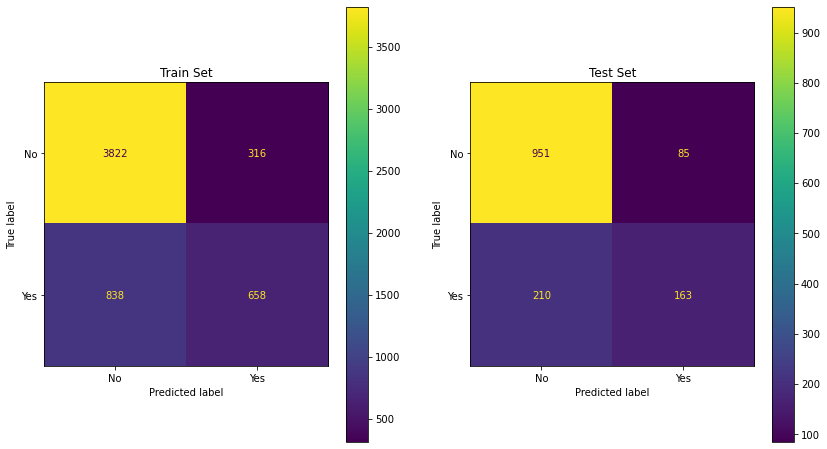

DecisionTreeClassifier(max_depth=5)

In [45]:
model_optimalK_numerical = DTC(optimalK_numerical, X_train, y_train, X_test, True)
model_optimalK_numerical

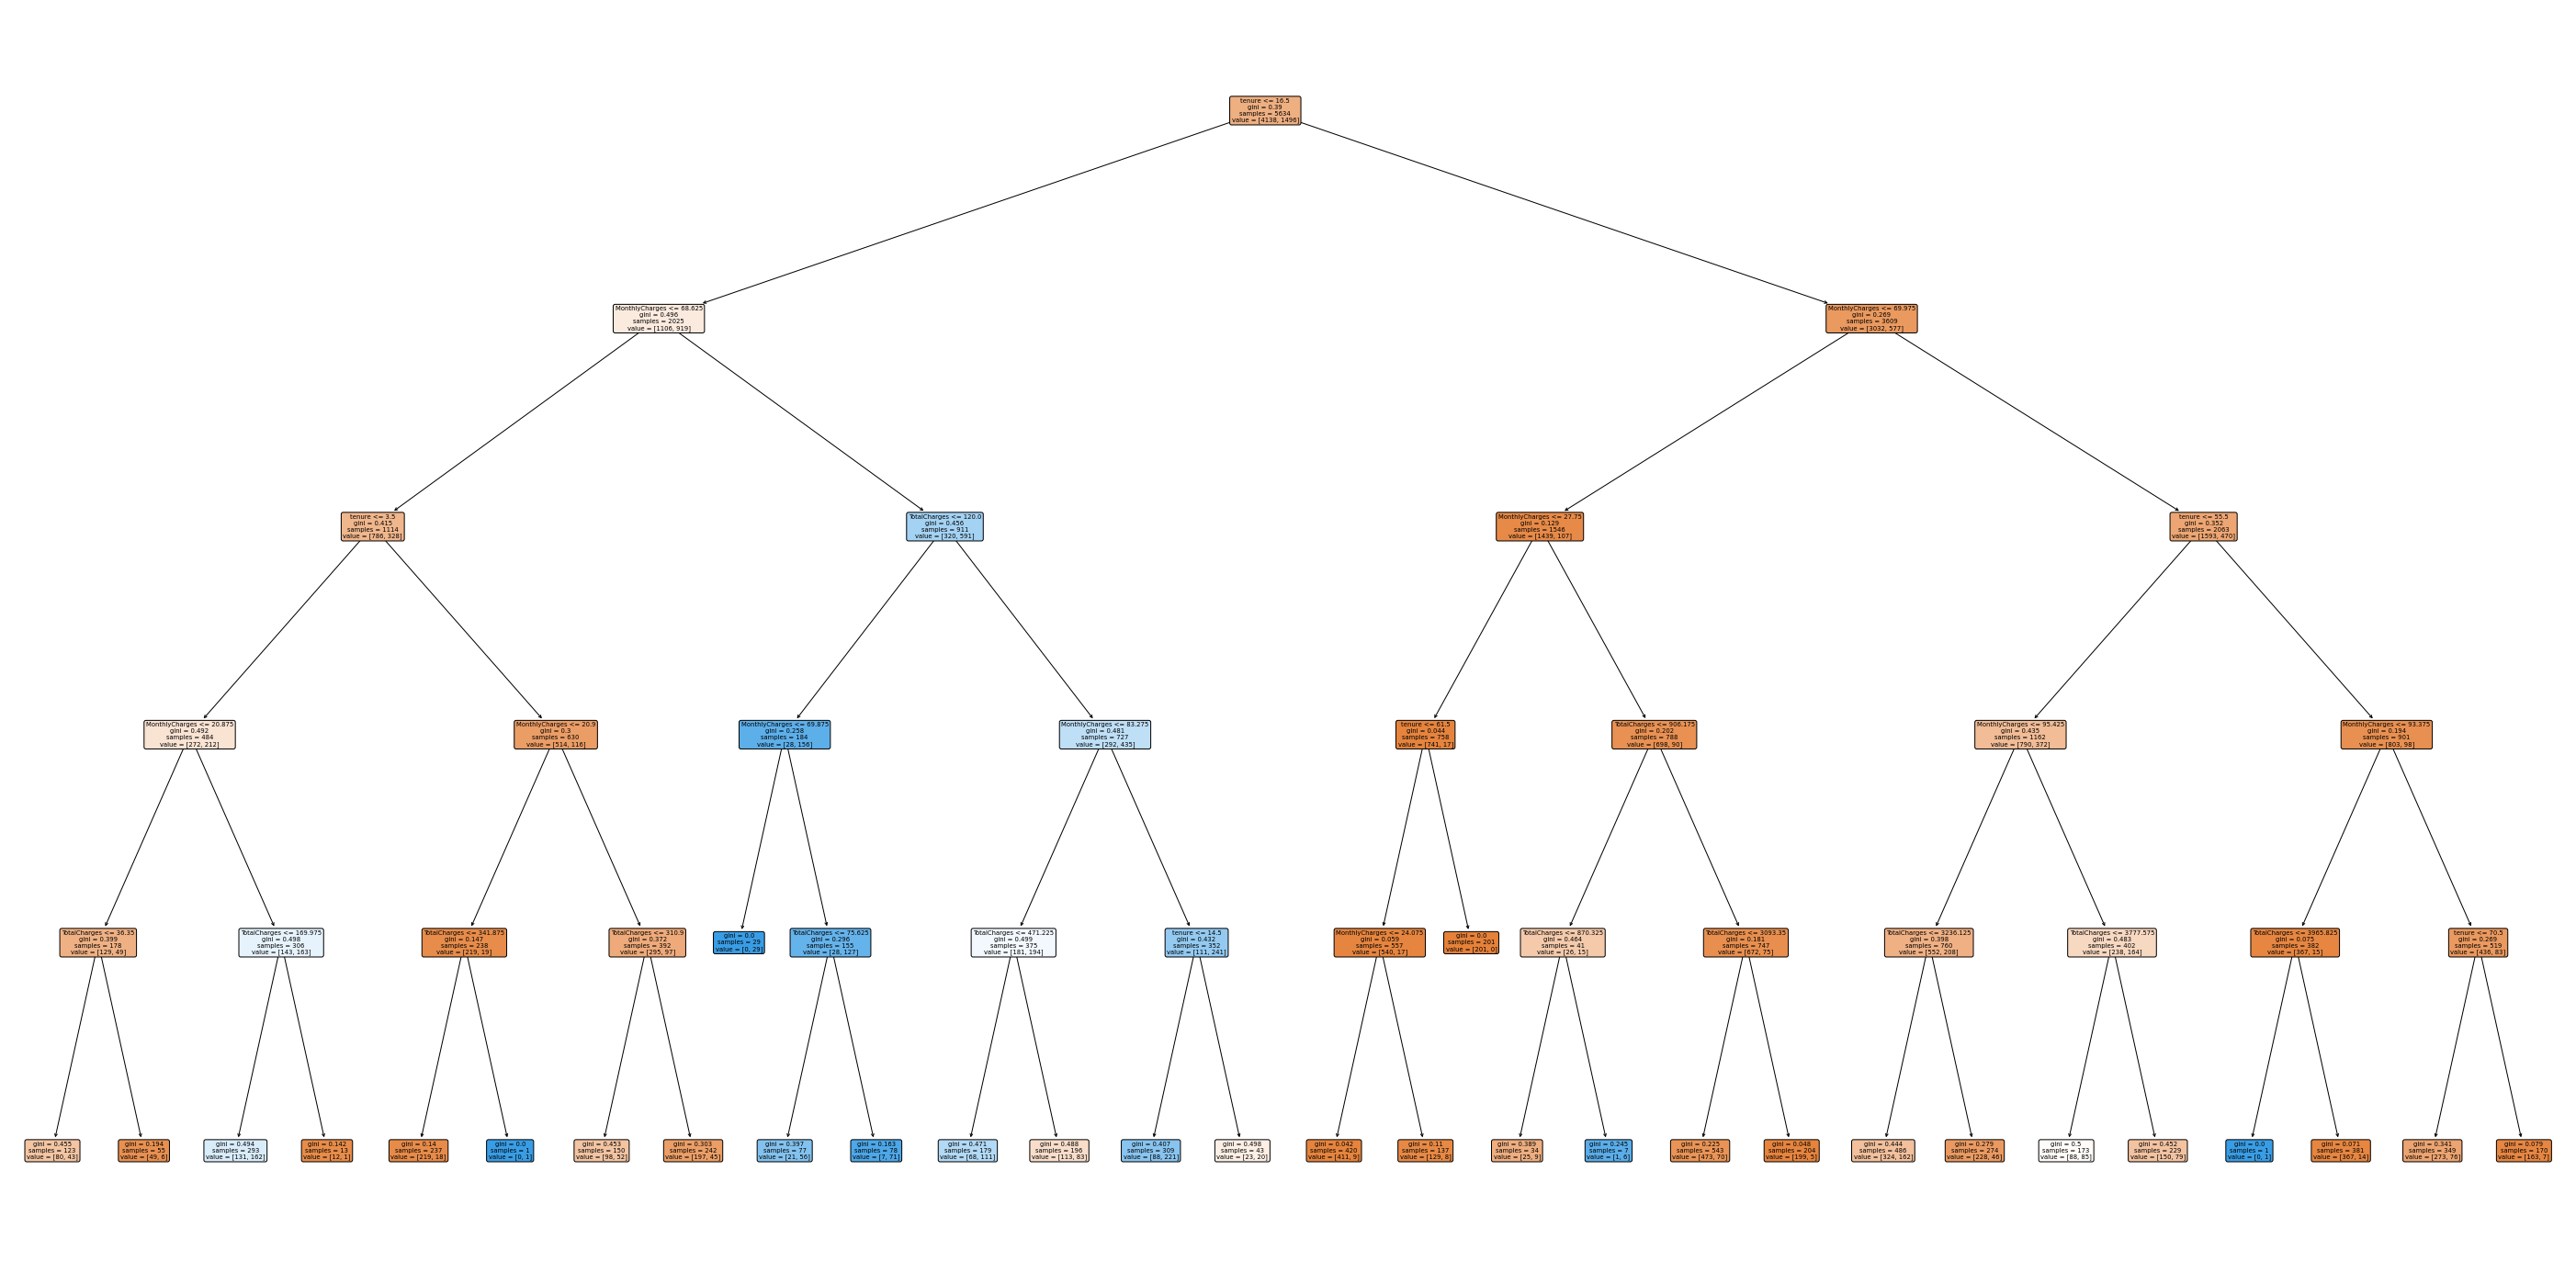

In [46]:
plot_decision_tree(model_optimalK_numerical, True, True, X_numerical.columns)

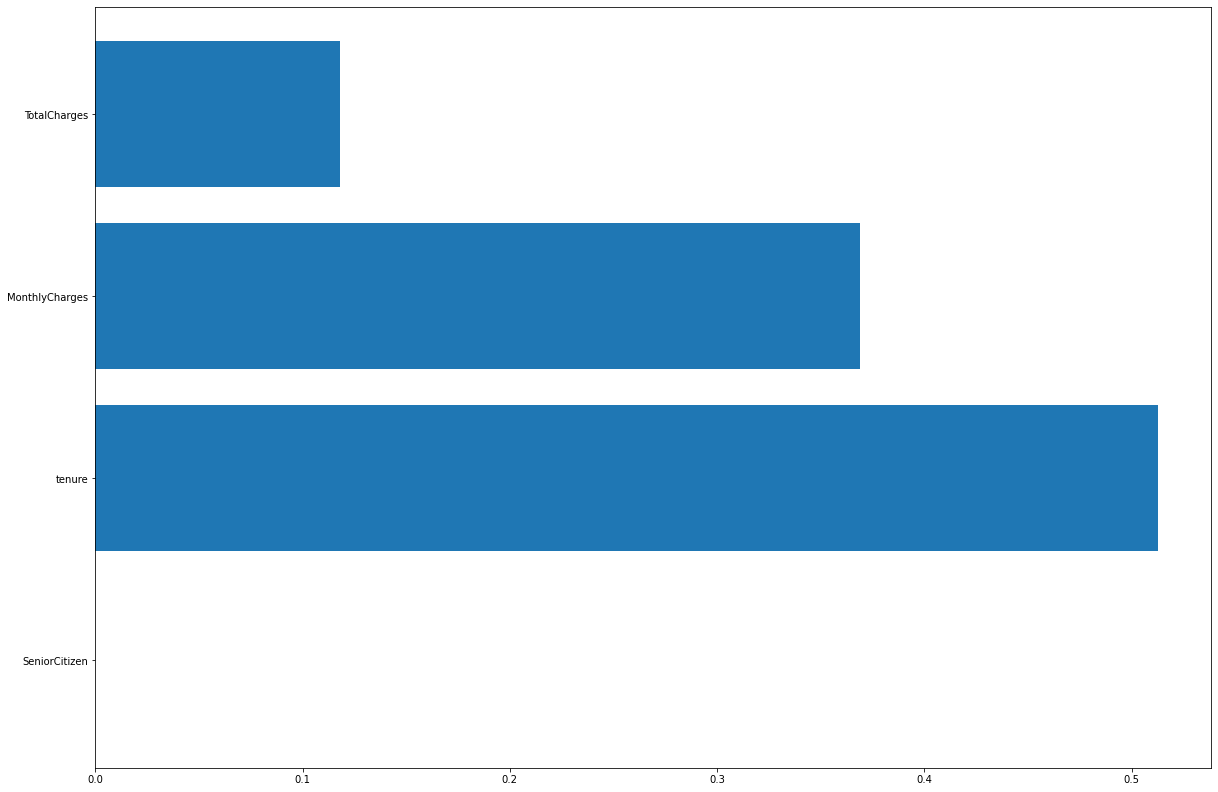

In [47]:
plot_feature_importances(model_optimalK_numerical, X_numerical.columns)

# Model Evaluation - Different Depths

In [48]:
X_train, X_test, y_train, y_test = get_X_y_train_test(X_hotcoded_combined, y, 0.2, 42)

In [49]:
performance_log = pd.DataFrame(columns=["Level", 'Accuracy_Train','Precision_Train','Recall_Train',
                                      'Accuracy_Test','Precision_Test','Recall_Test'])

Level_list = []
Accuracy_Train = []
Precision_Train = []
Recall_Train = []
Accuracy_Test = []
Precision_Test = []
Recall_Test = []

lvl_range = list(range(2, 30))

for lvl in lvl_range:
    #if k % 4 == 0:
        #print(f"k = {k}")
    model = DecisionTreeClassifier(max_depth = lvl)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    Level_list.append(lvl)
    Accuracy_Train.append(accuracy_score(y_train, y_pred_train))
    Precision_Train.append(precision_score(y_train, y_pred_train, pos_label="Yes"))
    Recall_Train.append(recall_score(y_train, y_pred_train, pos_label="Yes"))
    Accuracy_Test.append(accuracy_score(y_test, y_pred_test))
    Precision_Test.append(precision_score(y_test, y_pred_test, pos_label="Yes"))
    Recall_Test.append(recall_score(y_test, y_pred_test, pos_label="Yes"))
    
performance_log["Depth"] = Level_list
performance_log["Accuracy_Train"] = Accuracy_Train
performance_log["Precision_Train"] = Precision_Train
performance_log["Recall_Train"] = Recall_Train
performance_log["Accuracy_Test"] = Accuracy_Test
performance_log["Precision_Test"] = Precision_Test
performance_log["Recall_Test"] = Recall_Test



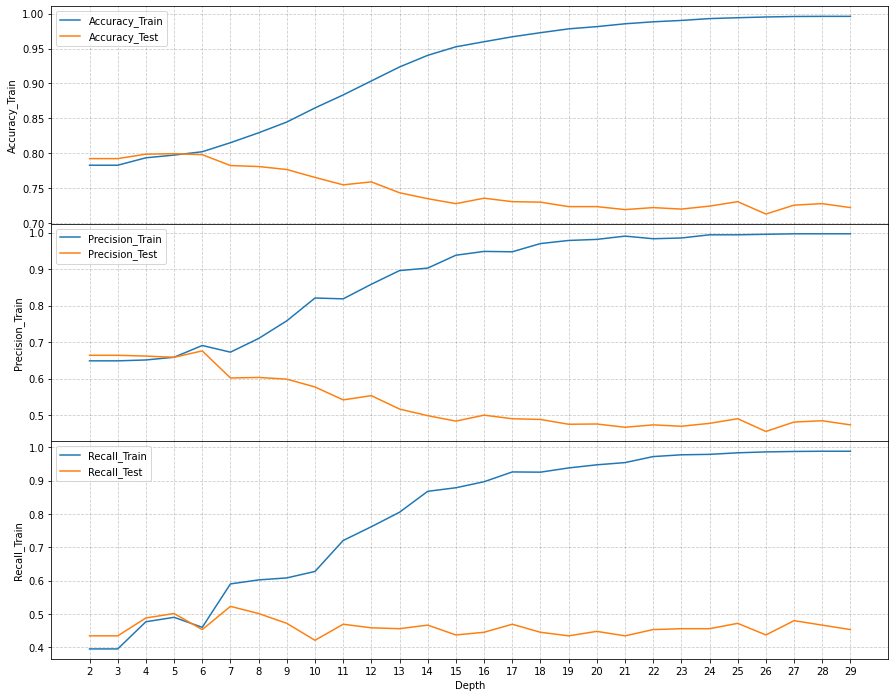

In [50]:
fig, ax = plt.subplots(3,1,figsize=(15,12))
#plt.suptitle("Model Evaluation", size=16, weight="bold")

ax[0].grid(ls="--", color="k", alpha=.2)
ax[1].grid(ls="--", color="k", alpha=.2)
ax[2].grid(ls="--", color="k", alpha=.2)

sns.lineplot(x = 'Depth', y = 'Accuracy_Train', data = performance_log, ax = ax[0], label = "Accuracy_Train")
sns.lineplot(x = 'Depth', y = 'Accuracy_Test', data = performance_log, ax = ax[0], label = "Accuracy_Test")
sns.lineplot(x = 'Depth', y = 'Precision_Train', data = performance_log, ax = ax[1], label = "Precision_Train")
sns.lineplot(x = 'Depth', y = 'Precision_Test', data = performance_log, ax = ax[1], label = "Precision_Test")
sns.lineplot(x = 'Depth', y = 'Recall_Train', data = performance_log, ax = ax[2], label = "Recall_Train")
sns.lineplot(x = 'Depth', y = 'Recall_Test', data = performance_log, ax = ax[2], label = "Recall_Test")

y_tick_range = list(range(2, 30,1))
ax[0].set_xticks(y_tick_range)
ax[1].set_xticks(y_tick_range)
ax[2].set_xticks(y_tick_range)
ax[0].tick_params(axis='x')
ax[1].tick_params(axis='x')
ax[2].tick_params(axis='x')

plt.setp(ax[0].get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax[1].yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.subplots_adjust(hspace=.0)

plt.show()